# Машинное обучение, DS-поток, осень 2024
## Задание ML.9

Задача 1: Простая полносвязная нейронная сеть.
▫️ Наличие решения. (40.0)
Баллы: 40.0 / 40.0

Задача 2: BatchNorm.
▫️ Наличие решения. (80.0)
▫️ Неправильно сделан вывод о решении проблемы ковариантного сдвига. Комм. Нужно сравнить именно различия распределений выходов разных батчей, а не эффект применения BN. . (-10.0)
Баллы: 70.0 / 80.0

Задача 3: Dropout.
▫️ Наличие решения. (50.0)
▫️ Нет графиков лосса. Комм. По ним можно увидеть переобучение и динамику в сравнении различных p в Dropout. (-5.0)
▫️ Нет вывода про скорость обучения. (-3.0)
▫️ Инд. комм. ошибки исполнения кода (-10.0)
Баллы: 32.0 / 50.0

**Баллы за задание**  
    1. Простая нейронная сеть &mdash; **40 баллов**  
    2. BatchNorm &mdash; **80 баллов**  
    3. Dropout &mdash; **50 баллов**   

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time
from collections import defaultdict

import numpy as np

import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

from IPython.display import clear_output
from tqdm import tqdm

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных.

In [18]:
transform = transforms.Compose([
    transforms.ToTensor()  # Преобразует PIL Image в тензор
])

In [19]:
train_source = FashionMNIST('fashionmnist', download=True, train=True, transform=transform)
test_source = FashionMNIST('fashionmnist', download=True, train=False, transform=transform)

100%|██████████| 26.4M/26.4M [00:23<00:00, 1.14MB/s]


Extracting fashionmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fashionmnist\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 327kB/s]


Extracting fashionmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fashionmnist\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.38MB/s]


Extracting fashionmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fashionmnist\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.65MB/s]

Extracting fashionmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fashionmnist\FashionMNIST\raw



Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [20]:
len(train_source.data), len(test_source.data)

(60000, 10000)

В датасете содержится 10 классов одежды.

In [21]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [22]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

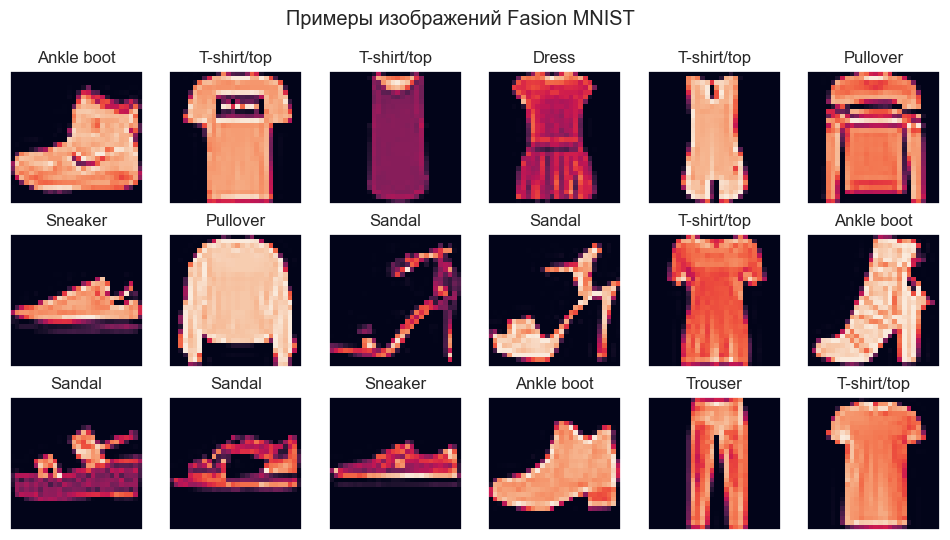

In [23]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image)
    axs[i][j].grid()
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

### 1. Простая полносвязная нейронная сеть

Сначала вспомним функцию обучения модели, которую мы уже много раз использовали.

In [30]:
def train(
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs,
        device,
        checkpoint_path=None,
):
    """
    # Обучение модели
    """
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss
            y_pred = torch.argmax(logits, axis=1)
            train_acc += (y_pred == y_batch).sum()
            train_size += y_batch.shape[0]

        # Подсчитываем лоссы и точность, сохраням в "историю"
        # train_loss = train_loss.cpu().numpy() / train_size
        # train_acc = train_acc.cpu().numpy() / train_size
        train_loss = train_loss.detach().cpu().numpy() / train_size
        train_acc = train_acc.detach().cpu().numpy() / train_size

        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            val_loss += loss
            y_pred = torch.argmax(logits, axis=1)
            val_acc += (y_pred == y_batch).sum()
            val_size += y_batch.shape[0]

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss = val_loss.cpu().detach().numpy() / val_size
        val_acc = val_acc.cpu().detach().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if (checkpoint_path is not None) and (val_acc > best_val_acc):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_acc = val_acc

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Постройте простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучите ее на тренировочной части данных. Можете использовать `SimpleDataset()` из семинара. Используйте кросс-энтропию в качестве функции ошибки. Добейтесь хотя бы 0.87 accuracy на тестовой части данных.

In [31]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 14 * 14),
    nn.ReLU(),
    nn.Linear(14 * 14, 10),
)

optim = torch.optim.Adam(model.parameters())
train_loader = DataLoader(train_source, batch_size=128)
val_loader = DataLoader(test_source, batch_size=128)
device = 'cpu'

In [32]:
train(model, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=10, device=device)

Epoch 10 of 10. Total time 77.175s
  training loss (in-iteration): 	0.002027
  validation loss (in-iteration): 	0.002660
  training accuracy: 			90.61 %
  validation accuracy: 			87.88 %


defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [0.00451527353922526,
                           0.003243817392985026,
                           0.0029113739013671876,
                           0.0026930569966634116,
                           0.0025304532368977863,
                           0.0023960973103841145,
                           0.0022872655232747396,
                           0.0021912584940592447,
                           0.0021065442403157553,
                           0.0020272064208984373],
                          'val': [0.0037103614807128906,
                           0.003320989227294922,
                           0.0031329309463500976,
                           0.0029966926574707033,
                           0.0029115631103515623,
                           0.002836271858215332,
                           0.002766741752624512,
                           0.002725573539

Визуализируйте "вероятности" предскаазнных моделью классов для нескольких изображений из теста. Для этого нужно применить SoftMax к выходам модели.

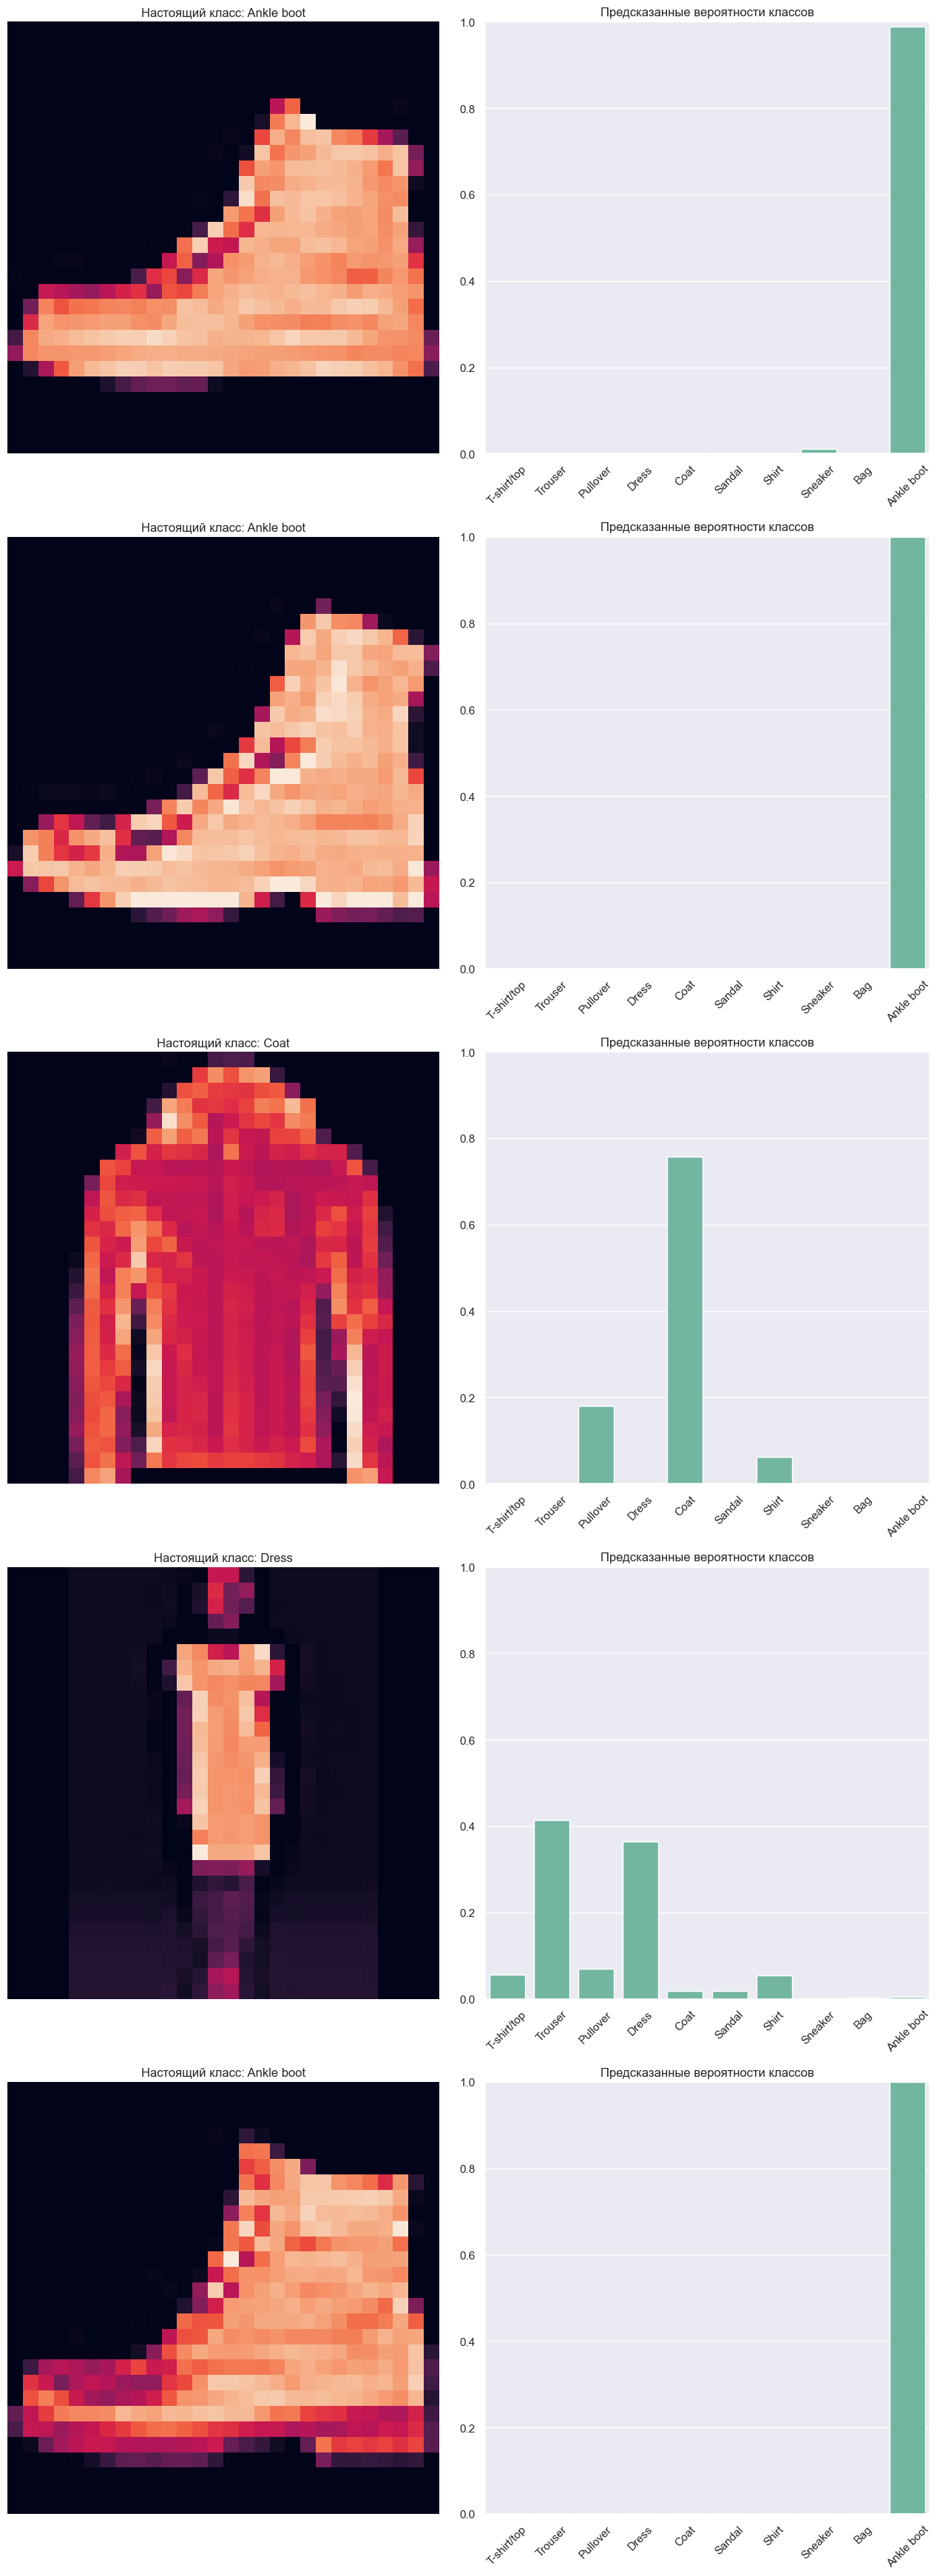

In [34]:
# Выбираем случайные изображения из тестового набора
ids = np.random.randint(0, len(test_source), size=5)

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 35))
model.eval()

# Проходим по выбранным изображениям и строим графики
for i, idx in enumerate(ids):
    image, label = test_source[idx]
    
    # Отображение изображения
    axes[i, 0].imshow(image.squeeze())
    axes[i, 0].set_title(f'Настоящий класс: {train_source.classes[label]}')
    axes[i, 0].axis('off')
    
    # Прогнозирование и получение вероятностей классов
    image_tensor = image.unsqueeze(0).to(device)  # Добавляем размерность батча
    logits = model(image_tensor)
    probs = nn.Softmax(dim=-1)(logits).detach().cpu().numpy().squeeze()
    
    # График вероятностей классов
    sns.barplot(x=np.arange(10), y=probs, ax=axes[i, 1])
    axes[i, 1].set_title('Предсказанные вероятности классов')
    axes[i, 1].set_xticks(np.arange(10))
    axes[i, 1].set_xticklabels(train_source.classes, rotation=45)
    axes[i, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

С платьем я бы, честно говоря, сама не догадалась. В остальном все правильно.

### 2. BatchNorm

Проверьте два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучите обе модели. Постройте графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравните эти графики с соответствующими графиками модели без BatchNorm. В этом пункте все графики распределений лучше строить с помощью `kdeplot`.

In [35]:
models = {
    # модель без батч-нормализации
    'no_bn': nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 14 * 14),
        nn.ReLU(),
        nn.Linear(14 * 14, 10),
    ),
    # модели с батч-нормализацией
    'bn_relu': nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 14 * 14),
        nn.BatchNorm1d(14 * 14),
        nn.ReLU(),
        nn.Linear(14 * 14, 10),
    ),
    'relu_bn': nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 14 * 14),
        nn.ReLU(),
        nn.BatchNorm1d(14 * 14),
        nn.Linear(14 * 14, 10),
    )
}

In [36]:
def calc_outputs(model, device):
    '''Считает выходы модели после 1, 2 и 3 слоев.
    Возвращает 3 тензора.'''
    model.train()
    outputs = {'l1': [], 'l2' : [], 'l3': []}
    for batch, _ in tqdm(train_loader):
        batch = batch.to(device)
        out0 = model[0](batch)
        out1 = model[1](out0)
        out2 = model[2](out1)
        out3 = model[3](out2)
        outputs['l1'].append(out1.detach().cpu())
        outputs['l2'].append(out2.detach().cpu())
        outputs['l3'].append(out3.detach().cpu())

    outputs['l1'] = torch.cat(outputs['l1'], axis=0)
    outputs['l2'] = torch.cat(outputs['l2'], axis=0)
    outputs['l3'] = torch.cat(outputs['l3'], axis=0)

    return outputs['l1'], outputs['l2'], outputs['l3']

Будем записывать выходы модели в `outputs`.

In [37]:
outputs = {name: {'l1': {}, 'l2': {}, 'l3': {}} for name in ('no_bn', 'bn_relu', 'relu_bn')}

In [39]:
for model_name, model in models.items():
    model = model.to(device)
    # выходы слоев перед обучением
    out = calc_outputs(model, device)
    outputs[model_name]['l1']['init'] = out[0]
    outputs[model_name]['l2']['init'] = out[1]
    outputs[model_name]['l3']['init'] = out[2]

    optim = torch.optim.Adam(model.parameters())
    train(model, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=3, device=device)

    # выходы слоев во время обучения во время обучения
    out = calc_outputs(model, device)
    outputs[model_name]['l1']['train'] = out[0]
    outputs[model_name]['l2']['train'] = out[1]
    outputs[model_name]['l3']['train'] = out[2]

    train(model, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=10, device=device)

    # выходы слоев после обучения модели
    out = calc_outputs(model, device)
    outputs[model_name]['l1']['final'] = out[0]
    outputs[model_name]['l2']['final'] = out[1]
    outputs[model_name]['l3']['final'] = out[2]

Epoch 10 of 10. Total time 88.412s
  training loss (in-iteration): 	0.001739
  validation loss (in-iteration): 	0.003179
  training accuracy: 			91.81 %
  validation accuracy: 			86.58 %


100%|██████████| 469/469 [00:06<00:00, 68.00it/s]


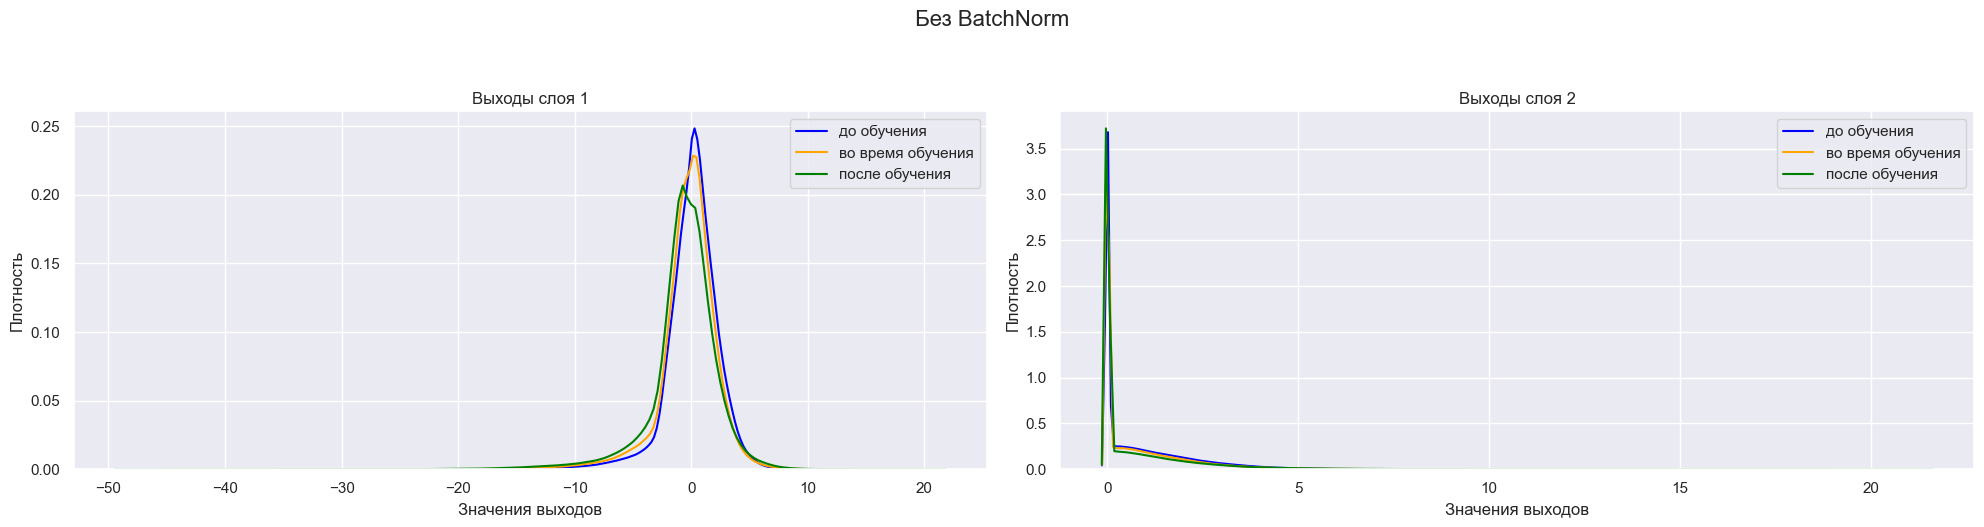

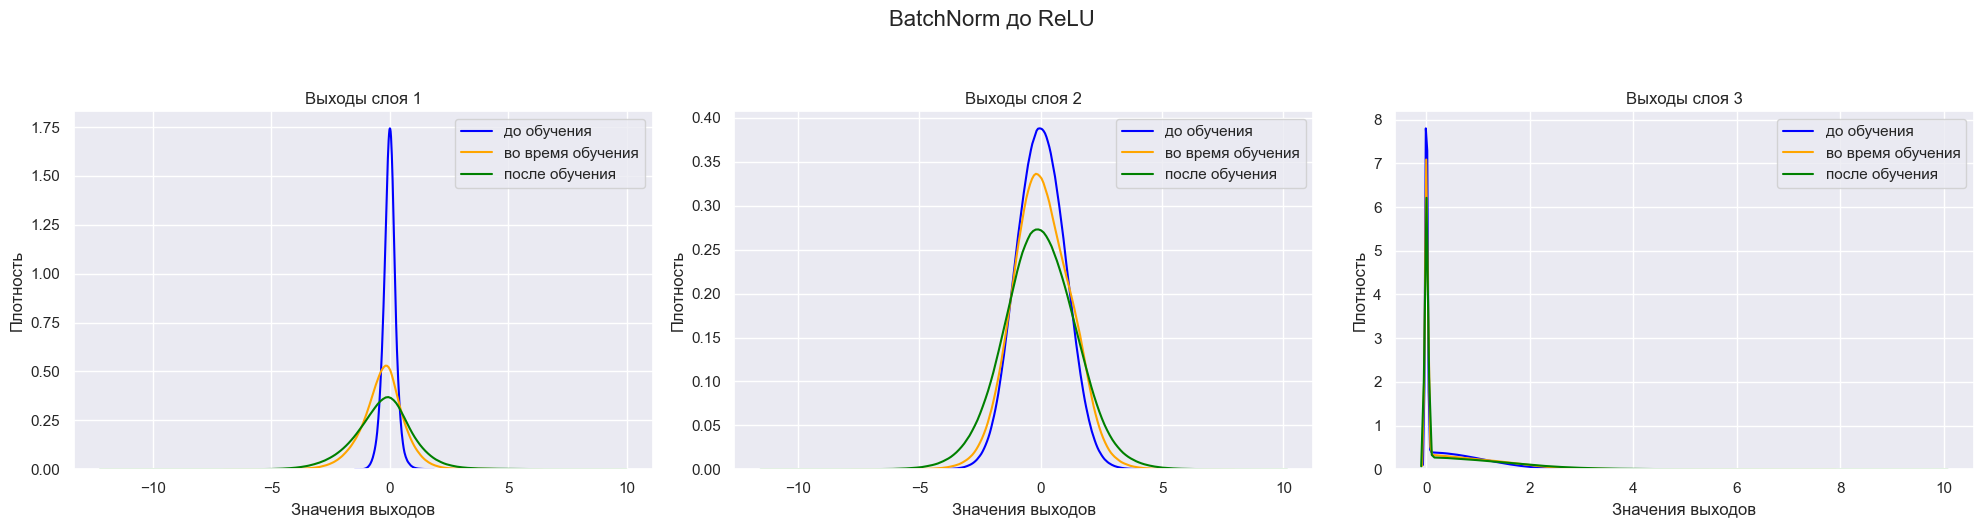

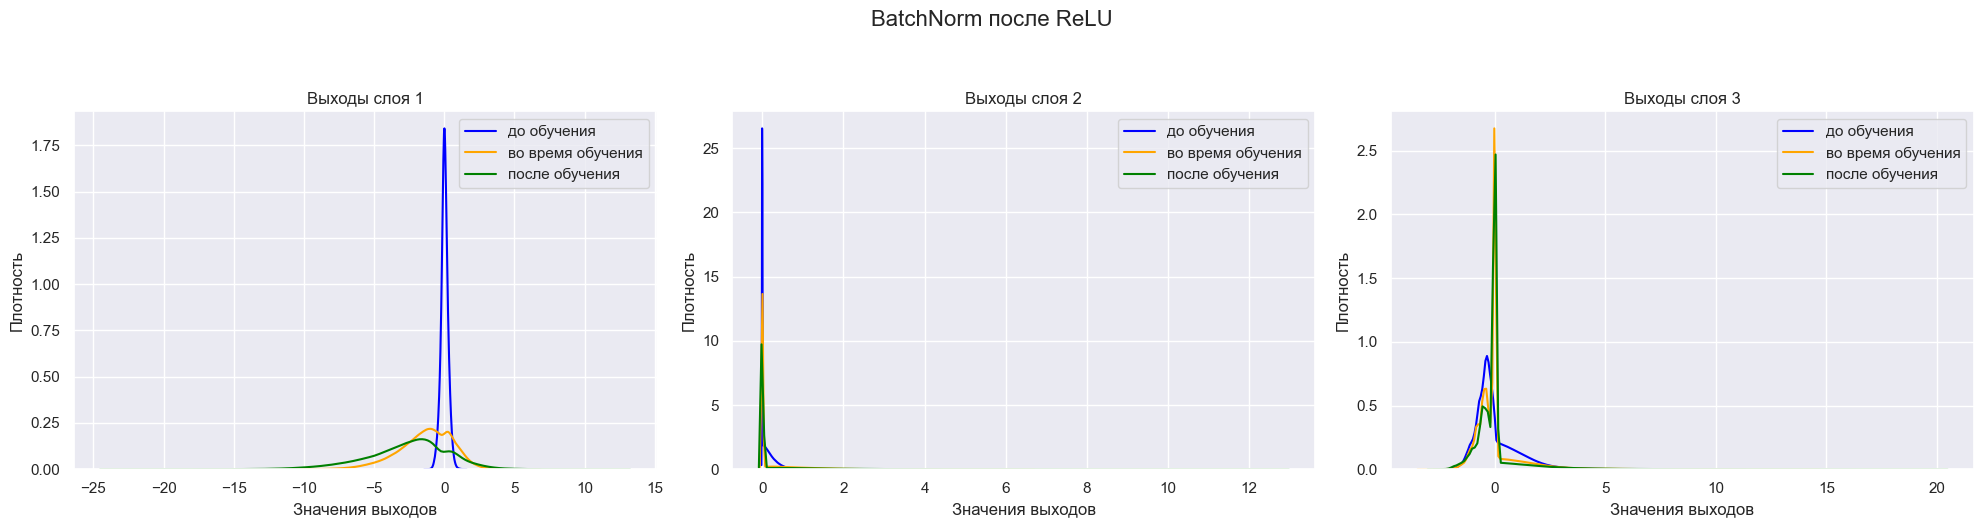

In [40]:
model_names = ['no_bn', 'bn_relu', 'relu_bn']
model_labels = ['Без BatchNorm', 'BatchNorm до ReLU', 'BatchNorm после ReLU']


for model_name, model_label in zip(model_names, model_labels):
    n_layers = 2 if model_name == 'no_bn' else 3
    fig, axes = plt.subplots(nrows=1, ncols=n_layers, figsize=(20, 5))
    
    
    for j in range(n_layers):
        layer_outputs = outputs[model_name][f'l{j + 1}']
        
        sns.kdeplot(layer_outputs['init'].ravel(), label='до обучения', ax=axes[j], color='blue')
        sns.kdeplot(layer_outputs['train'].ravel(), label='во время обучения', ax=axes[j], color='orange')
        sns.kdeplot(layer_outputs['final'].ravel(), label='после обучения', ax=axes[j], color='green')
        
        axes[j].set_title(f'Выходы слоя {j + 1}')
        axes[j].legend()
        axes[j].set_xlabel('Значения выходов')
        axes[j].set_ylabel('Плотность')

    fig.suptitle(model_label, fontsize=16, y=1.05)
    fig.tight_layout()

plt.show()

**Вывод:**
- Модель без батч нормализации:
Дисперсия, как и ожидалось, растет по мере обучения. Но у второго слоя дисперсия все равно значительно ниже.

- Модель батч нормализация + ReLU:
Также дисперсия растет по мере обучения. В итоге у второго слоя дисперсия сильно больше, чем у первого слоя, однако она и изначально большая, то есть изменения по мере обучения несильные.

- Модель ReLU + батч нормализация:
Дисперсия первого слоя почти не отличается от других моделей, но на втором слое все хорошо, дисперсия маленькая благодаря нормализации. Но у третьего слоя дисперсия больше чем у остальных моделей.


Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

In [41]:
seeds = [228, 1337, 322]
histories = []
for seed in tqdm(seeds):
    bn_relu = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 14 * 14),
        nn.BatchNorm1d(14 * 14),
        nn.ReLU(),
        nn.Linear(14 * 14, 10),
    )
    relu_bn = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 14 * 14),
        nn.ReLU(),
        nn.BatchNorm1d(14 * 14),
        nn.Linear(14 * 14, 10),
    )
    train_loader = DataLoader(train_source, batch_size=128, num_workers=2)
    val_loader = DataLoader(test_source, batch_size=128, num_workers=2)
    device = 'cpu'

    torch.manual_seed(seed)
    optim = torch.optim.Adam(bn_relu.parameters())
    history = train(bn_relu, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=10, device=device)
    histories.append(history)

    torch.manual_seed(seed)
    optim = torch.optim.Adam(relu_bn.parameters())
    history = train(relu_bn, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=10, device=device)
    histories.append(history)

100%|██████████| 3/3 [14:59<00:00, 299.79s/it]

Epoch 10 of 10. Total time 153.572s
  training loss (in-iteration): 	0.002023
  validation loss (in-iteration): 	0.002993
  training accuracy: 			90.63 %
  validation accuracy: 			86.46 %


<Figure size 640x480 with 0 Axes>

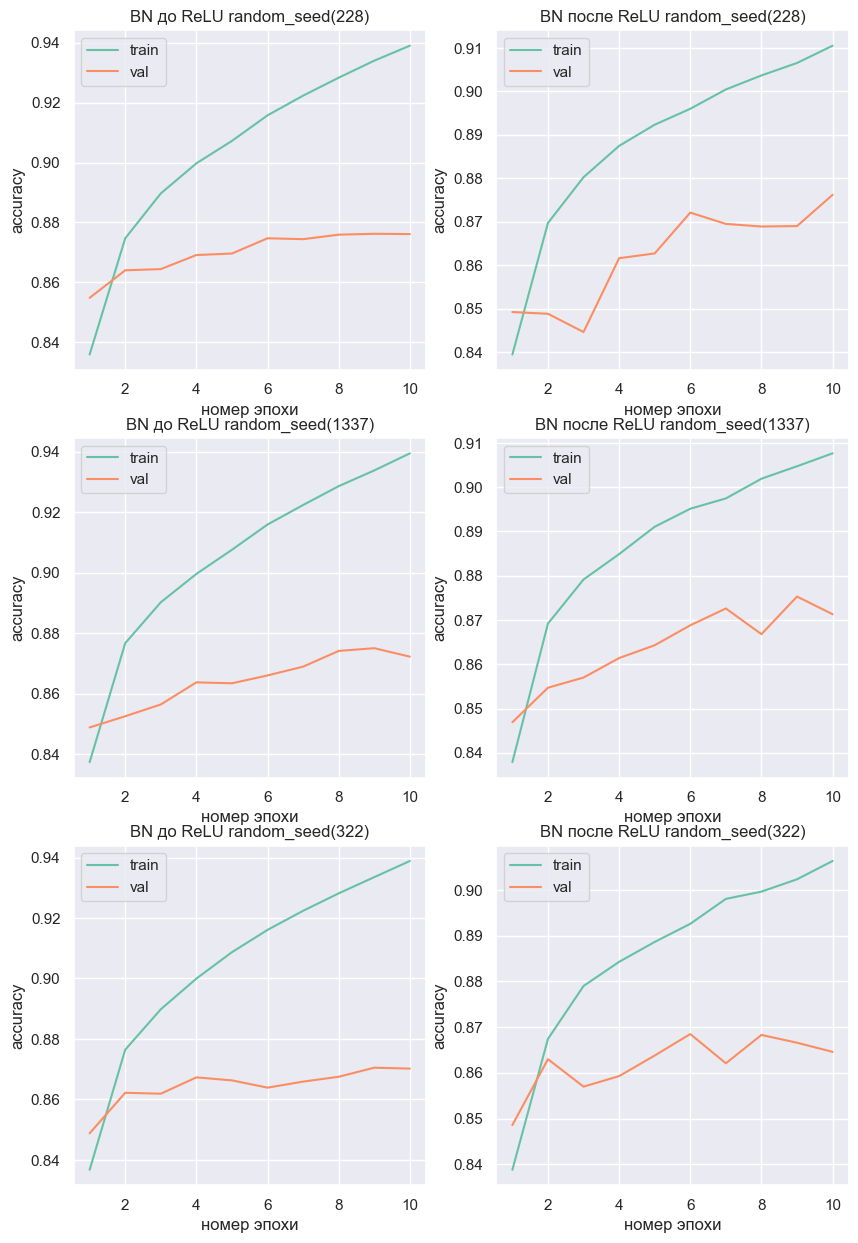

In [42]:
titles = ['BN до ReLU', 'BN после ReLU']
plt.tight_layout(pad=15.00)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
for i, hist in enumerate(histories):
    ax[i // 2, i % 2].plot(np.arange(10)+1, hist['acc']['train'], label='train')
    ax[i // 2, i % 2].plot(np.arange(10)+1, hist['acc']['val'], label='val')
    ax[i // 2, i % 2].set_title(titles[i % 2] + f' random_seed({seeds[i // 2]})')
    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_xlabel('номер эпохи')
    ax[i // 2, i % 2].set_ylabel('accuracy')

Когда нормализация после функции активации видим, что рост точности более скачкообразный

Выберите лучшую обученную модель с BatchNorm. Посмотрите на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных. Согласуются ли результаты с утверждением, что BatchNorm решает проблему ковариантного сдвига для батчей?



In [43]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 14 * 14),
    nn.BatchNorm1d(14 * 14),
    nn.ReLU(),
    nn.Linear(14 * 14, 10),
)
optim = torch.optim.Adam(model.parameters())
train(model, nn.CrossEntropyLoss(), optim, train_loader, val_loader, num_epochs=10, device=device)

Epoch 10 of 10. Total time 146.813s
  training loss (in-iteration): 	0.001371
  validation loss (in-iteration): 	0.002876
  training accuracy: 			93.95 %
  validation accuracy: 			87.51 %


defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [0.003648610432942708,
                           0.0026810567220052085,
                           0.002373247528076172,
                           0.002158167012532552,
                           0.001985177739461263,
                           0.0018406630198160808,
                           0.0017059949239095053,
                           0.0015843022664388021,
                           0.001470575968424479,
                           0.0013707443237304688],
                          'val': [0.0032575897216796873,
                           0.0030279037475585938,
                           0.002883235740661621,
                           0.0027856916427612304,
                           0.0027940067291259765,
                           0.002814432716369629,
                           0.002823506546020508,
                           0.00285066967010

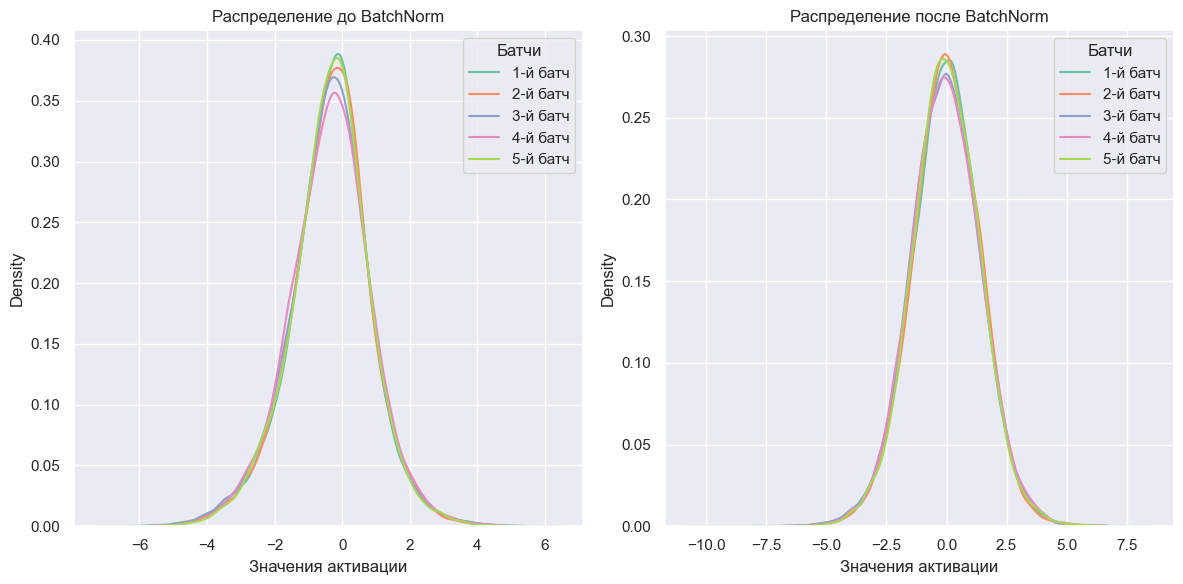

In [44]:
model.eval()

val_iter = iter(val_loader)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i in range(5):
    batch = next(val_iter)[0]
    
    # Проход через слои модели
    out0 = model[0](batch)
    out1 = model[1](out0)
    out2 = model[2](out1)
    out3 = model[3](out2)

    # Получаем значения перед и после BatchNorm
    out_before_bn = out1.detach().numpy().ravel()
    out_after_bn = out2.detach().numpy().ravel()
    
    # Графики распределений для каждого батча
    sns.kdeplot(out_before_bn, label=f'{i+1}-й батч', ax=axes[0])
    sns.kdeplot(out_after_bn, label=f'{i+1}-й батч', ax=axes[1])

axes[0].set_title('Распределение до BatchNorm')
axes[1].set_title('Распределение после BatchNorm')
axes[0].set_xlabel('Значения активации')
axes[1].set_xlabel('Значения активации')
axes[0].legend(title='Батчи')
axes[1].legend(title='Батчи')

plt.tight_layout()
plt.show()


**Ответ:**
Распределения почти одинаковые. Проблему ковариантного сдвига решили: выходы разных слоев имеют одинаковую дисперсию.

### 3. Dropout
Для начала добьемся переобучения модели. Это можно сделать, если использовать больше параметров в слое, дольше обучать или поменять параметры оптимизатора. Например, так:

In [47]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
)
DO_histories = []
DO_histories.append(
    train(
        model,
        nn.CrossEntropyLoss(),
        optimizer,
        train_loader,
        val_loader,
        num_epochs=60,
        device=device,
    )
)

Epoch 60 of 60. Total time 914.197s
  training loss (in-iteration): 	0.000916
  validation loss (in-iteration): 	0.004570
  training accuracy: 			95.82 %
  validation accuracy: 			86.44 %


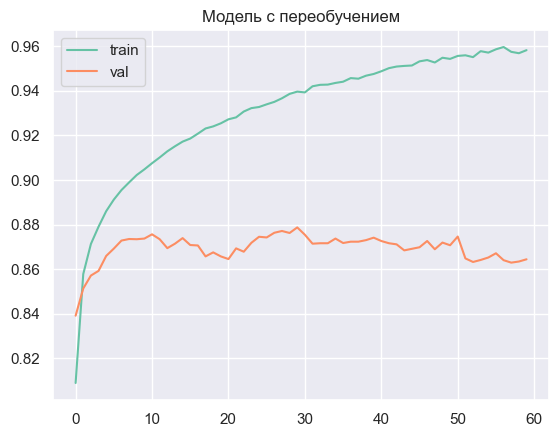

In [50]:
plt.plot(np.arange(len(DO_histories[0]['acc']['train'])), DO_histories[0]['acc']['train'], label='train')
plt.plot(np.arange(len(DO_histories[0]['acc']['val'])), DO_histories[0]['acc']['val'], label='val')
plt.title('Модель с переобучением')
plt.legend()

Добавьте Dropout в модель. Сравните скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

In [51]:
ps = [0.05, 0.1, 0.15, 0.2]
DO_histories = []

for p in tqdm(ps):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(100, 10),
    )
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-3,
    )
    DO_histories.append(
        train(
            model,
            nn.CrossEntropyLoss(reduction='sum'),
            optimizer,
            train_loader,
            val_loader,
            num_epochs=50,
            device=device,
        )
    )

Epoch 5 of 50. Total time 78.238s
  training loss (in-iteration): 	0.344054
  validation loss (in-iteration): 	0.368066
  training accuracy: 			87.46 %
  validation accuracy: 			86.66 %


 75%|███████▌  | 3/4 [41:05<13:41, 821.83s/it]


KeyboardInterrupt: 

Измерьте, насколько переобучаются модели в каждом случае - для этого посчитайте среднюю разность лосса на валидации и трейне (со знаком) на последних 10 или 20 эпохах.

IndexError: list index out of range

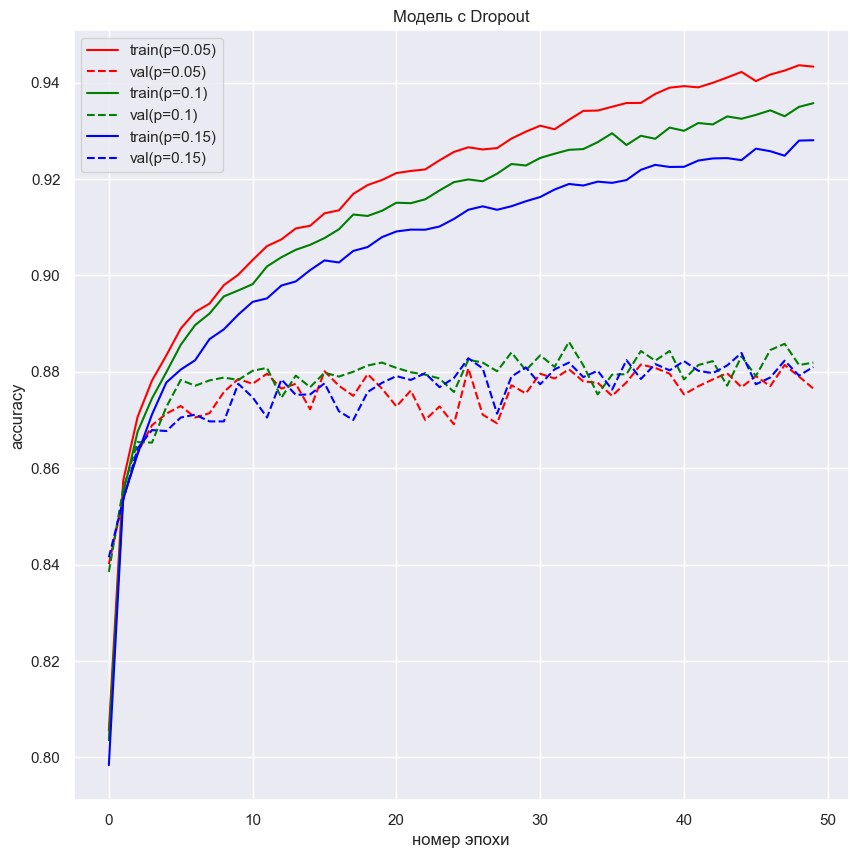

In [52]:
colors = ['red', 'green', 'blue', 'yellow']
plt.figure(figsize=(10, 10))
for i, p in enumerate(ps):
    plt.plot(np.arange(len(DO_histories[i]['acc']['train'])), DO_histories[i]['acc']['train'], label='train' + f'(p={p})', color=colors[i])
    plt.plot(np.arange(len(DO_histories[i]['acc']['val'])), DO_histories[i]['acc']['val'], label='val' + f'(p={p})', linestyle='--', color=colors[i])
    plt.legend()
    plt.xlabel('номер эпохи')
    plt.ylabel('accuracy')
    plt.title('Модель с Dropout')

In [53]:
print(DO_histories)

[defaultdict(<function train.<locals>.<lambda> at 0x000002290F98FF40>, {'loss': defaultdict(<class 'list'>, {'train': [0.5598403645833333, 0.40304436848958336, 0.3615860026041667, 0.3370155924479167, 0.31998310546875, 0.30346416015625, 0.2927177734375, 0.28464283854166667, 0.27415524088541665, 0.26651658528645833, 0.259740625, 0.252399267578125, 0.24755182291666666, 0.240975048828125, 0.23739231770833333, 0.231906689453125, 0.22771730143229166, 0.22102174479166667, 0.2175640625, 0.21444015299479166, 0.21025099283854168, 0.20862897135416666, 0.20696359049479165, 0.20064375, 0.197495947265625, 0.19473313802083334, 0.194473193359375, 0.19140924479166666, 0.18864479166666667, 0.185496875, 0.18344220377604167, 0.18264016927083335, 0.17832076822916668, 0.17231544596354167, 0.17281857096354167, 0.17076671549479167, 0.168198046875, 0.167601806640625, 0.16459537760416668, 0.1635642578125, 0.16385397135416666, 0.16098704427083332, 0.16014290364583333, 0.15867685546875, 0.15427291666666668, 0.154

In [54]:
for i, hist in enumerate(DO_histories):
    print(f'p={ps[i]}: train_loss - val_loss={(np.array(hist["loss"]["val"]) - np.array(hist["loss"]["train"]))[-20:].mean()}')

p=0.05: train_loss - val_loss=0.25850055460611976
p=0.1: train_loss - val_loss=0.19890453653971354
p=0.15: train_loss - val_loss=0.17653112589518233


**Вывод:**
Чем больше p, тем меньше разница между лоссом на трейне и на валидации.

Dropout препятствует переобучению модели.